# Advanced Tutorial : BOLFI model

## 1. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import warnings
warnings.filterwarnings('ignore')

## 2. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [2]:
import torch
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

# set bounds
bounds = torch.tensor([
    [-2,-2], # lower bound 
    [ 3, 3], # upper bound
])

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

### 2.1 Initial sampling

In [3]:
n_init = 10          # number of initial samples
random_seed = 50     # random seed that determines random behaviours
torch.manual_seed(random_seed)

X = prior.sample(n_init) # random samples
Y = BraninFunction(X).unsqueeze(-1)

### 2.2 Gaussian process modelling with BOLFI

In [4]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model

class QuadraticMean(gpytorch.means.Mean):                                                                                                                                                                     
    def __init__(self, input_size, batch_shape=torch.Size()):
        super().__init__()
        self.register_parameter(name='a', parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size)))
        self.register_parameter(name='b', parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size)))
        self.register_parameter(name='c', parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        
    def forward(self, x):
        return torch.einsum('...j, ...ij->...i', self.a, x.pow(2)) + torch.einsum('...j, ...ij->...i', self.b, x) + self.c

def set_rbf_model(X, Y):
    base_kernel = RBFKernel()
    covar_module = ScaleKernel(base_kernel)
    mean_module = QuadraticMean(X.shape[-1])

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(
        X, 
        train_Y, 
        likelihood=likelihood, 
        mean_module=mean_module,
        covar_module=covar_module,
    )
    return model

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### 2.3 Set experimental conditions

In [5]:
batch_size = 10    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 10        # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

### 2.4 Run!

In [7]:
import time
from SOBER._sober import Sober

model = set_rbf_model(X, Y)
sober = Sober(prior, model) # set SOBER wrapper

results = []
for n_iter in range(n_iterations):
    start = time.monotonic()
    model = set_rbf_model(X, Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    sober.update_model(model)     # pass the updated model to sober
    X_batch = sober.next_batch(
        n_rec,
        n_nys,
        batch_size,
        calc_obj=obj,
        verbose=False,
    )
    end = time.monotonic()
    interval = end - start
    
    Y_batch = BraninFunction(X_batch).unsqueeze(-1)
    X = torch.cat((X, X_batch), dim=0)
    Y = torch.cat((Y, Y_batch), dim=0)

    print(f"{len(X)}) Best value: {Y.max().item():.5e}")
    print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
    results.append([interval, Y.max().item()])

20) Best value: 4.49278e+00
Acquisition time [s]: 5.35522e+00, per sample [ms]: 5.35522e+02
30) Best value: 1.01822e+01
Acquisition time [s]: 8.20952e+00, per sample [ms]: 8.20952e+02
40) Best value: 1.03502e+01
Acquisition time [s]: 7.67139e+00, per sample [ms]: 7.67139e+02
50) Best value: 1.03502e+01
Acquisition time [s]: 8.71947e+00, per sample [ms]: 8.71947e+02
60) Best value: 1.05360e+01
Acquisition time [s]: 6.26989e+00, per sample [ms]: 6.26989e+02


### 2.5 Check convergence

Text(0, 0.5, 'overhead [s]')

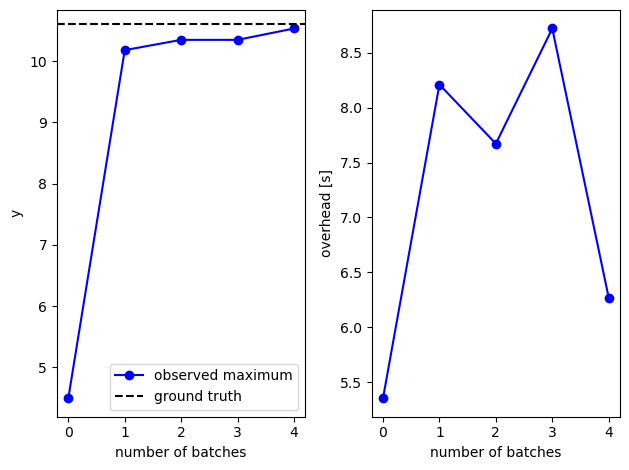

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
idx_batch = torch.arange(n_iterations)
results = torch.tensor(results)
ytrue = 10.604333877563477
ax1.plot(idx_batch, results[:,1], 'bo-', label="observed maximum")
ax1.axhline(y=ytrue, linestyle="--", color="k", label="ground truth")
ax1.legend()
ax1.set_xlabel("number of batches")
ax1.set_ylabel("y")

ax2.plot(idx_batch, results[:,0], 'bo-')
ax2.set_xlabel("number of batches")
ax2.set_ylabel("overhead [s]")